# モデルの汎化性能

### 予測誤差の平均 = バイアス + バリアンス

バイアス・・・観測データが変わったときに平均的にどれくらい予測するかという指標

バリアンス・・・観測データが変わったときにどのくらい予測値がばらつくかという指標

$$
    E_D\Bigl[\bigr(f(x)-\hat{f_D}(x)\bigl)^2\Bigr]=\Bigl(f(x)-E_D[\hat{f_D}(x)]\Bigl)^2+E_D\Bigl[\bigl(\hat{f_D}(x)-E_D[\hat{f}(x)]\bigr)^2\Bigr]
$$

バイアスだけを見て，汎化性能の判断は禁物。なぜなら，平均値が目的値に達していても，ばらつきが大きい場合があるから。観測データによっては大きな誤差を生む可能性がある。

### 以下の関数を線形回帰と多項式回帰で予測して，両者のバイアスとバリアンスを比較する実験

$$
    y = \frac{1}{1+x}\quad(0 \leq x \leq 5)
$$

以下を10万回繰り返す

1. $0 \leq x \leq5$の範囲に5点をランダムに取り，それらについて$f(x)=\frac{1}{1+x}$を計算する
2. 上記のデータにより，線形回帰と多項式回帰をそれぞれ学習させる
3. 0から5まで0.01刻みに予測値を，線形回帰と多項式回帰のそれぞれについて計算する

最後に0から5まで0.01刻みに予測値の平均を，線形回帰と多項式回帰それぞれについて計算し，図示する

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import linalg
% matplotlib inline

class LinearRegression:
    def __init__(self):
        self.w_ = None
        
    def fit(self, X, t):
        Xtil = np.c_[np.ones(X.shape[0]), X]
        A = np.dot(Xtil.T, Xtil)
        b = np.dot(Xtil.T, t)
        self.w_ = linalg.solve(A, b)
        
    def predict(self, X):
        Xtil = np.c_[np.ones(X.shape[0]), X]
        return np.dot(Xtil, self.w_)
    
class PolynominalRegression:
    def __init__(self, degree):
        self.degree_ = degree
        
    def fit(self, X, t):
        x_pow = []
        x = X.reshape(len(X), 1)
        for i in range(1, self.degree_ + 1):
            x_pow.append(x**i) # x_iの累乗の縦ベクトル
        mat = np.concatenate(x_pow, axis=1) # 列方向に連結
        
        linreg = LinearRegression()
        linreg.fit(mat, t)
        self.w_ = linreg.w_
        
    def predict(self, X):
        r = 0
        for i in range(self.degree_ + 1):
            r += X**i * self.w_[i]
        return r

In [8]:
def f(x):
    return 1 / (x + 1)

def sample(n):
    x = np.random.random(n) * 5
    y = f(x)
    return x, y

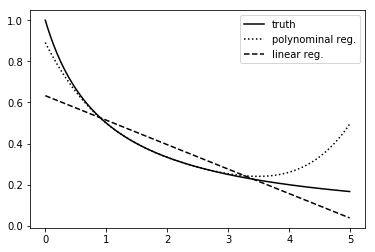

In [9]:
xx = np.arange(0, 5, 0.01)
np.random.seed(0)
y_poly_sum = np.zeros(len(xx))
y_lin_sum = np.zeros(len(xx))
n = 100000
warnings.filterwarnings("ignore")

for _ in range(n):
    x, y = sample(5)
    poly = PolynominalRegression(4) # ４乗まで
    poly.fit(x, y)
    lin = LinearRegression()
    lin.fit(x, y)
    y_poly = poly.predict(xx)
    y_poly_sum += y_poly
    y_lin = lin.predict(xx)
    y_lin_sum += y_lin
    
fig, ax = plt.subplots()
ax.plot(xx, f(xx), label="truth", color="k", linestyle="solid")
ax.plot(xx, y_poly_sum / n, label="polynominal reg.", color="k", linestyle="dotted")
ax.plot(xx, y_lin_sum / n, label="linear reg.", color="k", linestyle="dashed")
ax.legend()
plt.show()

結果から多項式回帰の方が真値(truth)によく当てはまっているように見える。ここで，わかることは，__「5点を取って全体を予測する」ということを多く繰り返して，平均を取ると線形回帰より多項式回帰のほうが真値に近くなる！__

なので，多項式回帰の方が良いモデル！と結論づけようとしたくなるが，__まだバリアンスを確認していない！__

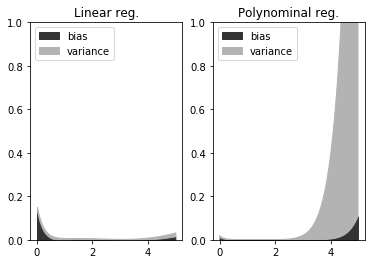

In [10]:
xx = np.arange(0, 5, 0.01)
np.random.seed(0)
y_poly_sum = np.zeros(len(xx))
y_lin_sum = np.zeros(len(xx))
y_poly_sum_sq = np.zeros(len(xx))
y_lin_sum_sq = np.zeros(len(xx))
y_true = f(xx)

n = 100000
warnings.filterwarnings("ignore")

for _ in range(n):
    x, y = sample(5)
    poly = PolynominalRegression(4) # ４乗まで
    poly.fit(x, y)
    lin = LinearRegression()
    lin.fit(x, y)
    y_poly = poly.predict(xx)
    y_poly_sum += y_poly
    y_poly_sum_sq += (y_poly - y_true)**2 # 予測誤差全体
    y_lin = lin.predict(xx)
    y_lin_sum += y_lin
    y_lin_sum_sq += (y_lin - y_true)**2 # 予測誤差全体
    
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title("Linear reg.")
ax2.set_title("Polynominal reg.")
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)

ax1.fill_between(xx, 0, (y_true - y_lin_sum / n)**2, color="0.2", label="bias")
ax1.fill_between(xx, (y_true - y_lin_sum / n)**2, y_lin_sum_sq / n, color="0.7", label="variance")
ax1.legend(loc="upper left")

ax2.fill_between(xx, 0, (y_true - y_poly_sum / n)**2, color="0.2", label="bias")
ax2.fill_between(xx, (y_true - y_poly_sum / n)**2, y_poly_sum_sq / n, color="0.7", label="variance")
ax2.legend(loc="upper left")
plt.show()

積み上げグラフの差分がバリアンス。多項式回帰の方が，$x>3$の範囲でバリアンスが著しく増加している。
結果として，グラフの右側では予測値と真値の差がおおきくばらつく。平均を取ると真の曲線に当てはまっているが，
大きく上や下に外すことも多い事がわかる。

対策として，ホールド・アウト検証やクロスバリデーションを行う。